# 6. Predictive Modeling With Sklearn & Error Analysis
Train machine learning models, evaluate their performance, and use them to make predictions.

Now that we have looked at the data in more depth, we can start to forecast the dependent variable t1 for the unknown.csv dataset.

**In this notebook we compare the Linear Regression and CatBoost Regressor models. Here, the train-test split, predicting and evaluating are hard coded.**

- **We import the algorithms from scikit-learn which we want to use.**
- **We determine the models, often there are additional hyperparameters we have to specify.**
- **We determine which variables to pass to the models.**
- **We train the models (we call the method `.fit(X_train, y_train)` on our models).**
- **We test the models with our test data and get the adjusted R^2 as metric (we call the method `.score(X_test, y_test)` on our trained models and clean up the score).**
- **We plot geographical coordinates on a map and compare the predicted target variable of the unseen data with the train data to determine which model has a higher prediction accuracy (R^2 score).**

## Import Libraries

In [1]:
# Basic import(s)
import pandas as pd

# Visualization libraries
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Hide all warnings in ipython
import warnings
warnings.filterwarnings('ignore')

## Import Featured Datasets

In [2]:
# Loading of the known.csv dataset via pandas.
known_dataset = pd.read_csv('data/featured_known.csv')
train_dataset = known_dataset

In [3]:
# Loading of the unknown.csv dataset via pandas.
unknown_dataset = pd.read_csv('data/featured_unknown.csv')
test_dataset = unknown_dataset

## Preparation

In [4]:
train_dataset.head()

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
0,14.25,52.17,11.0,2403.0,890.0,344.0,3.0000,497.0,120800.0,1,6.99,0.21,2
1,14.11,52.20,15.0,5644.0,2659.0,783.0,6.7559,757.0,312000.0,2,7.21,0.13,5
2,14.26,52.10,52.0,2084.0,1438.0,516.0,2.3087,550.0,258600.0,3,4.04,0.26,2
3,11.47,53.09,32.0,3011.0,1287.0,525.0,5.0605,529.0,311000.0,4,5.74,0.18,4
4,11.46,53.03,33.0,2824.0,1797.0,493.0,3.6359,523.0,135100.0,5,5.73,0.19,3


In [5]:
test_dataset.head()

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
0,13.28,52.63,34.0,3850.0,1619.0,602.000000,5.0465,608.000000,0.0,1,6.400000,0.16,4
1,13.31,52.45,21.0,5041.0,2719.0,441.277473,3.5335,470.986642,0.0,2,5.202722,0.09,3
2,13.39,52.40,52.0,1509.0,674.0,244.000000,4.9306,225.000000,0.0,3,6.180000,0.15,4
3,13.46,52.59,42.0,1291.0,1535.0,332.000000,1.9083,345.000000,0.0,4,3.890000,0.27,2
4,13.22,52.51,27.0,4742.0,1682.0,696.000000,6.1940,775.000000,0.0,5,6.810000,0.16,4


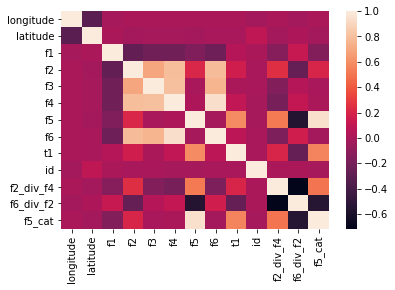

In [6]:
# Check for independence between features.
sns.heatmap(train_dataset.corr());

## Feature Selection

In [7]:
drop_lst = ['f5']

In [8]:
# We would like to consider all variables except the ones mentioned above.
all_features = [x for x in train_dataset.columns if x not in drop_lst]

In [9]:
# Check selected features for ML.
print(all_features)

['longitude', 'latitude', 'f1', 'f2', 'f3', 'f4', 'f6', 't1', 'id', 'f2_div_f4', 'f6_div_f2', 'f5_cat']


In [10]:
# X contains all descriptive variables defined above.
X = train_dataset[all_features]

In [11]:
# We define y (our dependent variable): we take t1.
y = train_dataset.t1

## Train-Test split

In [12]:
# We separate our data into train and test data. In the process, 20 % of the data is used for the subsequent testing of the prognostic quality.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# we can look at how much data is in each dataset
print("X_train (features for the model to learn from): ", X_train.shape)
print("y_train (labels for the model to learn from): ", y_train.shape)
print("X_test (features to test the model's accuracy against): ", X_test.shape)
print("y_test (labels to test the model's accuracy with): ", y_test.shape)

X_train (features for the model to learn from):  (11996, 12)
y_train (labels for the model to learn from):  (11996,)
X_test (features to test the model's accuracy against):  (2999, 12)
y_test (labels to test the model's accuracy with):  (2999,)


In [14]:
# If we look at the first 5 lines of our training data, we see that the index is no longer sorted, it has been shuffled.
X_train.head()

,longitude,latitude,f1,f2,f3,f4,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
6786,12.54,53.15,19.0,1765.0,868.0,388.0,394.0,260300.000000,6792,4.55,0.22,2
9837,13.81,53.05,31.0,1404.0,1515.0,387.0,379.0,56400.000000,9843,3.63,0.27,1
7688,13.44,53.07,52.0,2002.0,939.0,501.0,520.0,191930.965289,7694,4.00,0.26,3
6556,13.43,52.05,31.0,2447.0,1313.0,352.0,465.0,93800.000000,6562,6.95,0.19,3
11323,14.07,53.09,17.0,2761.0,1128.0,482.0,501.0,139700.000000,11329,5.73,0.18,3


## Modeling

After these preparations, we now come to modelling. 
For this we will continue to use the scikit-learn library, in which many different algorithms are implemented.
The procedure is always the same:

- We import the algorithm from scikit-learn which we want to use.
- We determine the model, often there are additional hyperparameters we have to specify.
- We determine which variables to pass to the model.
- We train the model (we call the method `.fit(X_train, y_train)` on our model).
- We test the model with our test data and get the adjusted R^2 as metric (we call the method `.score(X_test, y_test)` on our trained model and clean up the score).

In [15]:
# We determine the model Linear Regression.
linear_reg_model = LinearRegression().fit(X_train, y_train)

In [16]:
# We determine the model Cat Boost Regressor. 
cat_model = CatBoostRegressor().fit(X_train,y_train)

Learning rate set to 0.060627
0:	learn: 88787.9113327	total: 183ms	remaining: 3m 2s
1:	learn: 83969.3522228	total: 186ms	remaining: 1m 32s
2:	learn: 79246.3012238	total: 189ms	remaining: 1m 2s
3:	learn: 74766.9251036	total: 192ms	remaining: 47.7s
4:	learn: 70496.6516494	total: 195ms	remaining: 38.8s
5:	learn: 66582.4862585	total: 198ms	remaining: 32.8s
6:	learn: 62886.8063637	total: 202ms	remaining: 28.6s
7:	learn: 59530.5170302	total: 205ms	remaining: 25.4s
8:	learn: 56329.3536589	total: 208ms	remaining: 22.9s
9:	learn: 53269.9066105	total: 211ms	remaining: 20.9s
10:	learn: 50213.9618283	total: 214ms	remaining: 19.3s
11:	learn: 47443.9532551	total: 217ms	remaining: 17.9s
12:	learn: 44851.1872810	total: 220ms	remaining: 16.7s
13:	learn: 42396.5302256	total: 223ms	remaining: 15.7s
14:	learn: 40044.3118063	total: 227ms	remaining: 14.9s
15:	learn: 37819.6472850	total: 230ms	remaining: 14.1s
16:	learn: 35731.1917268	total: 233ms	remaining: 13.5s
17:	learn: 33747.6871877	total: 236ms	remain

## Predicting And Evaluating Different Models

We determine the models:

In [17]:
# We determine which variables we pass to the model
variables = ['f5_cat']

In [18]:
# Training of the Linear Regression model:
linear_reg_model.fit(X_train[variables], y_train)

LinearRegression()

In [19]:
# Training of the CatBoost Regressor model:
cat_model.fit(X_train[variables], y_train)

Learning rate set to 0.060627
0:	learn: 92321.7813190	total: 1.5ms	remaining: 1.5s
1:	learn: 90727.8953437	total: 3.17ms	remaining: 1.58s
2:	learn: 89297.3127154	total: 4.86ms	remaining: 1.62s
3:	learn: 88040.7597712	total: 6.76ms	remaining: 1.68s
4:	learn: 86916.5695410	total: 8.49ms	remaining: 1.69s
5:	learn: 85912.0800332	total: 9.89ms	remaining: 1.64s
6:	learn: 85054.0977623	total: 11.1ms	remaining: 1.58s
7:	learn: 84289.6531531	total: 12.4ms	remaining: 1.54s
8:	learn: 83569.8921254	total: 13.8ms	remaining: 1.52s
9:	learn: 82901.9770978	total: 15.5ms	remaining: 1.53s
10:	learn: 82339.0272966	total: 17ms	remaining: 1.53s
11:	learn: 81807.5510180	total: 18.7ms	remaining: 1.54s
12:	learn: 81382.6615079	total: 20.2ms	remaining: 1.53s
13:	learn: 80958.3965127	total: 21.9ms	remaining: 1.54s
14:	learn: 80582.0198624	total: 23.5ms	remaining: 1.54s
15:	learn: 80248.3059961	total: 25ms	remaining: 1.54s
16:	learn: 79966.0919762	total: 26.4ms	remaining: 1.52s
17:	learn: 79716.1598473	total: 27

In [20]:
# We look at how well our Linear Regression model performs on the test data.
print('adj. R^2:', (1-(1-linear_reg_model.score(X_test[variables], y_test))*(X_test.shape[0]- 1)/(X_test.shape[0]-len(variables)-1)).round(2))

adj. R^2: 0.33


In [21]:
# We look at how well our CatBoost Regressor model performs on the test data.
print('adj. R^2:', (1-(1-cat_model.score(X_test[variables], y_test))*(X_test.shape[0]- 1)/(X_test.shape[0]-len(variables)-1)).round(2))

adj. R^2: 0.33


The adjusted R^2 indicates the percentage of variance of the target variable (t1) explained by the model. Adjusted R² is a modified version of R² that has been adjusted with the number of explanatory variables. It penalises the addition of unnecessary variables and allows comparison of regression models with different numbers of explanatory variables.
The value 1 means 100 % of the variance of the target variable could be explained by the model. The value 0 means 0 % of the variance of the target variable could be explained by the model. 
This means for our case: The variable "f5_cat" can explain `33%` (Linear Regression) and `33%` (CatBoost Regressor) of the variance in the t1 target variable of our test set.
Perhaps more variables could explain more variance. 
We can look again at what variables we have:

Here are four of the common metrics for evaluating regression tasks:

**Mean Absolute Error** (MAE) is a very simple metric which calculates the absolute difference between actual and predicted values. MAE is the average of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is a most used and very simple metric with a little bit of change in mean absolute error. Mean squared error states that finding the squared difference between actual and predicted value. MSE is the average of the squared Errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RSME) is the square root of the average of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**R Squared (R2)** $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)

$$R^2 = \frac{SSR}{SST}$$

SST = SSR + SSE

* Total sum of squares (**SST**): $\sum_{i=1}^n (y_i - \bar{y})^2$


* Regression sum of squares (**SSR**): $\sum_{i=1}^n (\hat{y}_i - \bar{y})^2$


* Residual sum of squares (**SSE**): $\sum_{i=1}^n e_i^2$ 

Compare these matrices:

* **MAE** is easiest to understand as it gives the average error.
* **MSE** is more common, as MSE "penalises" the larger errors, which is useful in the real world.
* **RSME** is even more common than MSE, as RMSE can be interpreted in "y" units.

All three are so-called *loss functions*, since we want to minimise them!

* **R2** score is a metric that tells the performance of our model, not the loss in an absolute sense that how many wells did our model perform.

## Model Optimization

In [22]:
# Names of the variables in the dataset.
X_train.columns

Index(['longitude', 'latitude', 'f1', 'f2', 'f3', 'f4', 'f6', 't1', 'id',
       'f2_div_f4', 'f6_div_f2', 'f5_cat'],
      dtype='object')

In [23]:
linear_reg_model = LinearRegression()

In [24]:
cat_model = CatBoostRegressor()

We can use all these variables to predict the target variable t1.
Therefore, we will now try a new linear regression with these 3 variables.

In [25]:
# We determine which variables we pass to the model.
variables = ['f6_div_f2', 'f2_div_f4', 'f5_cat']

In [26]:
# We train the Linear Regression model.
linear_reg_model.fit(X_train[variables], y_train)

LinearRegression()

In [27]:
# We train the CatBoost Regressor model.
cat_model.fit(X_train[variables], y_train)

Learning rate set to 0.060627
0:	learn: 92229.5103337	total: 2.04ms	remaining: 2.04s
1:	learn: 90511.4016518	total: 4.56ms	remaining: 2.28s
2:	learn: 89011.8853675	total: 6.84ms	remaining: 2.27s
3:	learn: 87644.6563362	total: 8.7ms	remaining: 2.17s
4:	learn: 86382.0156295	total: 10.9ms	remaining: 2.17s
5:	learn: 85226.2111169	total: 13.1ms	remaining: 2.17s
6:	learn: 84207.5905627	total: 15.6ms	remaining: 2.21s
7:	learn: 83375.1008989	total: 17.6ms	remaining: 2.18s
8:	learn: 82555.4463089	total: 19.8ms	remaining: 2.18s
9:	learn: 81824.1456006	total: 22.3ms	remaining: 2.21s
10:	learn: 81157.9543003	total: 24.6ms	remaining: 2.21s
11:	learn: 80555.0857547	total: 26.8ms	remaining: 2.21s
12:	learn: 80024.0468605	total: 29.1ms	remaining: 2.21s
13:	learn: 79613.2114135	total: 30.7ms	remaining: 2.16s
14:	learn: 79140.3778037	total: 33ms	remaining: 2.17s
15:	learn: 78730.3810003	total: 35.3ms	remaining: 2.17s
16:	learn: 78364.2642685	total: 37.6ms	remaining: 2.18s
17:	learn: 78043.9198440	total:

In [28]:
# We look at how well our Linear Regression model performs on the test data.
print('adj. R^2:', (1-(1-linear_reg_model.score(X_test[variables], y_test))*(X_test.shape[0]- 1)/(X_test.shape[0]-len(variables)-1)).round(2))

adj. R^2: 0.34


In [29]:
# We look at how well our CatBoost Regressor model performs on the test data.
print('adj. R^2:', (1-(1-cat_model.score(X_test[variables], y_test))*(X_test.shape[0]- 1)/(X_test.shape[0]-len(variables)-1)).round(2))

adj. R^2: 0.36


We see that with this additional variables, `34%` (Linear Regression) and `36%` (CatBoost Regressor) of the variance in the target variable t1 could be explained.

So far we have only looked at the linear relationships between the variables and the target variable t1. However, it is possible that the relationship is not linear, but rather quadratic. 
We can easily extend our model by squaring our variables. Thus, instead of:

$t1 = b*(INPUTVARIABLE) + c$

we can also use 

$t1=a*(INPUTVARIABLE)^{2}+b*(INPUTVARIABLE)+c$

can be obtained.
This is a type of feature engineering. We will apply it to our complete dataset and see if we can improve our model even further.

In [30]:
# We want to create only polynomial variables of second order (^2).
poly = PolynomialFeatures(2)

In [31]:
# We create new variables by calling poly.
X_train_sq = poly.fit_transform(X_train)

# We have to do the same for our test data, of course.
X_test_sq = poly.transform(X_test)

In [32]:
# We determine the model, there must be 2 round brackets behind the model name!
linear_reg_model = LinearRegression()

In [33]:
cat_model = CatBoostRegressor()

In [34]:
# We also train the model with squared variables for Linear Regression.
linear_reg_model.fit(X_train_sq, y_train)

LinearRegression()

In [35]:
# We also train the model with squared variables for CatBoost Regressor.
cat_model.fit(X_train_sq, y_train)

Learning rate set to 0.060627
0:	learn: 88787.8931716	total: 19.9ms	remaining: 19.8s
1:	learn: 83854.9597252	total: 32ms	remaining: 16s
2:	learn: 79331.1408653	total: 44.9ms	remaining: 14.9s
3:	learn: 74904.0518590	total: 71.1ms	remaining: 17.7s
4:	learn: 70630.2436386	total: 82.2ms	remaining: 16.4s
5:	learn: 66669.8200304	total: 93.9ms	remaining: 15.6s
6:	learn: 63128.3286621	total: 105ms	remaining: 15s
7:	learn: 59665.0098793	total: 124ms	remaining: 15.4s
8:	learn: 56379.7529342	total: 134ms	remaining: 14.8s
9:	learn: 53267.5971141	total: 145ms	remaining: 14.4s
10:	learn: 50366.4967999	total: 156ms	remaining: 14.1s
11:	learn: 47602.9032140	total: 167ms	remaining: 13.7s
12:	learn: 44988.9402705	total: 178ms	remaining: 13.5s
13:	learn: 42554.0897490	total: 189ms	remaining: 13.3s
14:	learn: 40241.9366706	total: 201ms	remaining: 13.2s
15:	learn: 38019.7164774	total: 213ms	remaining: 13.1s
16:	learn: 35940.1211905	total: 224ms	remaining: 13s
17:	learn: 33947.1673325	total: 235ms	remaining

In [36]:
# We look at how well our Linear Regression model performs on the test data.
print('adjusted R^2:', (1-(1-linear_reg_model.score(X_test_sq, y_test))*(X_test_sq.shape[0]- 1)/(X_test_sq.shape[0]-X_test_sq.shape[1]-1)).round(2))

adjusted R^2: 1.0


In [37]:
# We look at how well our CatBoost Regressor model performs on the test data.
print('adjusted R^2:', (1-(1-cat_model.score(X_test_sq, y_test))*(X_test_sq.shape[0]- 1)/(X_test_sq.shape[0]-X_test_sq.shape[1]-1)).round(2))

adjusted R^2: 1.0


With the additional squared variables, we were able to improve our results: `100%` for Linear Regression our CatBoost Regressor model!

With the adjusted R^2 value we have a possibility to evaluate the quality of our model, but it may be worthwhile to have a look at the real errors of the model graphically. This may help to identify systematic errors.
For ease of interpretation, we choose the percentage t1 difference between our forecast and the true values.

We see a few outliers here. We can take a closer look at the highest one. 

In [38]:
# Error analysis for Linear Regression & CatBoost Regressor model:
# In order to better analyse the errors of our model, we create a new dataframe with the
# columns "t1" (the target variable), as well as the latitudes and longitudes.
y_predictions_linear_reg_model = linear_reg_model.predict(X_test_sq)
df_error_linear_reg_model = pd.DataFrame(y_test)
df_error_linear_reg_model['latitude'] = X_test['latitude']
df_error_linear_reg_model['longitude'] = X_test['longitude']
df_error_linear_reg_model['id'] = X_test['id']
df_error_linear_reg_model.head(2)

,t1,latitude,longitude,id
13410,139500.0,53.09,13.19,13416
6472,73100.0,53.35,13.69,6478


In [39]:
# Error analysis for CatBoost Regressor model:
# In order to better analyse the errors of our model, we create a new dataframe with the
# columns "t1" (the target variable), as well as the latitudes and longitudes.
y_predictions_cat_model = cat_model.predict(X_test_sq)
df_error_cat_model = pd.DataFrame(y_test)
df_error_cat_model['latitude'] = X_test['latitude']
df_error_cat_model['longitude'] = X_test['longitude']
df_error_cat_model['id'] = X_test['id']
df_error_cat_model.head(2)

,t1,latitude,longitude,id
13410,139500.0,53.09,13.19,13416
6472,73100.0,53.35,13.69,6478


In [40]:
# Linear Regression model:
# To add the predicted t1 as a column as well, we must first reset the index.
df_error_linear_reg_model.reset_index(inplace=True, drop=True)
df_error_linear_reg_model.head(2)

,t1,latitude,longitude,id
0,139500.0,53.09,13.19,13416
1,73100.0,53.35,13.69,6478


In [41]:
# CatBoost Regressor model:
# To add the predicted t1 as a column as well, we must first reset the index.
df_error_cat_model.reset_index(inplace=True, drop=True)
df_error_cat_model.head(2)

,t1,latitude,longitude,id
0,139500.0,53.09,13.19,13416
1,73100.0,53.35,13.69,6478


In [42]:
# Now we can also add the predicted t1 as a column and calculate the difference for our Linear Regression model.
df_error_linear_reg_model['t1_prediction_linear_reg_model'] = y_predictions_linear_reg_model.round(2)
df_error_linear_reg_model['t1_difference_linear_reg_model'] = (df_error_linear_reg_model['t1_prediction_linear_reg_model'] - df_error_linear_reg_model['t1']).round(2)
df_error_linear_reg_model['t1_difference_percent_linear_reg_model'] = ((df_error_linear_reg_model['t1_difference_linear_reg_model']/df_error_linear_reg_model['t1'])*100).round(2)
df_error_linear_reg_model.head(2)

,t1,latitude,longitude,id,t1_prediction_linear_reg_model,t1_difference_linear_reg_model,t1_difference_percent_linear_reg_model
0,139500.0,53.09,13.19,13416,139500.0,0.0,0.0
1,73100.0,53.35,13.69,6478,73100.0,0.0,0.0


In [43]:
# Now we can also add the predicted t1 as a column and calculate the difference for our CatBoost Regressor model.
df_error_cat_model['t1_prediction_cat_model'] = y_predictions_cat_model.round(2)
df_error_cat_model['t1_difference_cat_model'] = (df_error_cat_model['t1_prediction_cat_model'] - df_error_cat_model['t1']).round(2)
df_error_cat_model['t1_difference_percent_cat_model'] = ((df_error_cat_model['t1_difference_cat_model']/df_error_cat_model['t1'])*100).round(2)
df_error_cat_model.head(2)

,t1,latitude,longitude,id,t1_prediction_cat_model,t1_difference_cat_model,t1_difference_percent_cat_model
0,139500.0,53.09,13.19,13416,138911.08,-588.92,-0.42
1,73100.0,53.35,13.69,6478,71624.18,-1475.82,-2.02


In [44]:
# Linear Regression model.
fig = px.scatter_mapbox(df_error_linear_reg_model,
                        lat="latitude",
                        lon="longitude",
                        hover_data=["t1", "t1_prediction_linear_reg_model", 'id'],
                        color='t1_difference_percent_linear_reg_model',
                        color_continuous_scale=['blue', 'grey', 'red'],
                        zoom=6,
                        height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [45]:
# CatBoost Regressor model.
fig = px.scatter_mapbox(df_error_cat_model,
                        lat="latitude",
                        lon="longitude",
                        hover_data=["t1", "t1_prediction_cat_model", 'id'],
                        color='t1_difference_percent_cat_model',
                        color_continuous_scale=['blue', 'grey', 'red'],
                        zoom=6,
                        height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [46]:
# Linear Regression model.
df_error_linear_reg_model[df_error_linear_reg_model['t1_difference_percent_linear_reg_model']==df_error_linear_reg_model['t1_difference_percent_linear_reg_model'].max()]

,t1,latitude,longitude,id,t1_prediction_linear_reg_model,t1_difference_linear_reg_model,t1_difference_percent_linear_reg_model
0,139500.0,53.09,13.19,13416,139500.0,0.0,0.0
1,73100.0,53.35,13.69,6478,73100.0,0.0,0.0
2,192800.0,53.12,13.78,9973,192800.0,0.0,0.0
3,94000.0,52.38,13.26,868,94000.0,0.0,0.0
4,72800.0,51.62,14.26,5973,72800.0,0.0,0.0
...,...,...,...,...,...,...,...
2994,115200.0,52.12,14.64,8197,115200.0,0.0,0.0
2995,83200.0,51.74,13.76,3303,83200.0,0.0,0.0
2996,332400.0,52.61,12.55,14115,332400.0,0.0,0.0
2997,346100.0,52.20,14.34,5519,346100.0,0.0,0.0


In [47]:
# CatBoost Regressor model.
df_error_cat_model[df_error_cat_model['t1_difference_percent_cat_model']==df_error_cat_model['t1_difference_percent_cat_model'].max()]

,t1,latitude,longitude,id,t1_prediction_cat_model,t1_difference_cat_model,t1_difference_percent_cat_model
2318,14999.0,53.15,13.54,4929,31910.56,16911.56,112.75


In [48]:
X_test[X_test['id']==4929]

,longitude,latitude,f1,f2,f3,f4,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
4923,13.54,53.15,19.0,619.0,490.0,164.0,239.0,14999.0,4929,3.77,0.205033,2


## Regularisation And Hyperparameter Tuning Of Linear Regression And CatBoost Regressor

In addition to our variables, we have also passed the squared variables to our last linear model. So we have passed a lot of variables to our model. Some may have no effect on the t1 at all. However, models try to extract some information from all variables. This leads to random variance in the data also being recognised as a pattern. This phenomenon is called "overfitting" the model to the data.
For each algorithm there are ways to prevent this overfitting.

In the case of linear regression, we force the model not to use variables for forecasting. We "regularise" the model. But instead of us telling the model which variables not to use, we let the model learn which variables offer the least added value and remove those variables (in the case of linear regression, variables are no longer considered if the learned coefficient (b) is zero). How much we regularise is up to us.
[Here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) we can find information on the ElasticNet model used.
To find out how much we should regularize our model, we can test different values for the regularzation parameters and see which will give us the best model. For this purpose we can use [GridSearch](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) with [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

In [49]:
# We specify which hyperparameters we want to change:
# alpha: specifies how much we regularise:
param_grid = {'alpha':[0.1,.5,1,5,10,],
             'l1_ratio': [1,0.5,0]}

# We determine the model, there must be 2 round brackets behind the model name!
elastic = ElasticNet(max_iter=50000, tol=0.2)

# Passing the model to a so-called parameter grid with 5-fold cross-validation.
elastic_cv= GridSearchCV(elastic,param_grid,cv=5, verbose=True,n_jobs=-1)

# We train the model and optimise it via GridSearch.
elastic_cv.fit(X_train_sq,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.9s finished


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=50000, tol=0.2), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 5, 10],
                         'l1_ratio': [1, 0.5, 0]},
             verbose=True)

In [50]:
# Output of the best parameters found by the GridSearch.
elastic_cv.best_params_

{'alpha': 0.5, 'l1_ratio': 0}

In [51]:
# We train the model with the optimal hyperparameters.
elastic = ElasticNet(max_iter=50000, tol=0.2,**elastic_cv.best_params_)

elastic.fit(X_train_sq, y_train)

ElasticNet(alpha=0.5, l1_ratio=0, max_iter=50000, tol=0.2)

In [52]:
# We look at how well our model performs on the test data.
adj_r2 = (1-(1-elastic.score(X_test_sq, y_test))*(X_test_sq.shape[0]- 1)/(X_test_sq.shape[0]-(X_test_sq.shape[1]-sum(elastic.coef_== 0))-1)).round(2)
print('adjusted R^2:',adj_r2 )

adjusted R^2: 1.0


We were able to further improve our model through hyperparameter tuning and regularisation. 
As mentioned above, regularisation eliminates variables from the forecast. This is done by giving the coefficients of the linear regression a value of zero. With the following code we can look at the learned coefficients (here only a section of the first 5 coefficients) and see that for the first variable a coefficient of zero was calculated. This variable was therefore removed by our regularisation.

In [53]:
# Output of the first 5 learned coefficients of linear regression.
elastic.coef_[0:5]

array([  0.        ,  48.00467757,  -3.23615613, 389.48020608,
        14.38335489])

In [54]:
# Error analysis:
# In order to better analyse the errors of our model, we create a new dataframe with the
# columns "t1" (the real target variable), as well as the latitudes and longitudes.
y_predictions = elastic.predict(X_test_sq)
df_error = pd.DataFrame(y_test)
df_error['latitude'] = X_test['latitude']
df_error['longitude'] = X_test['longitude']
df_error['id'] = X_test['id']
df_error.head(2)

,t1,latitude,longitude,id
13410,139500.0,53.09,13.19,13416
6472,73100.0,53.35,13.69,6478


In [55]:
# To add the predicted t1 as a column as well, we must first reset the index.
df_error.reset_index(inplace=True, drop=True)
df_error.head(2)

,t1,latitude,longitude,id
0,139500.0,53.09,13.19,13416
1,73100.0,53.35,13.69,6478


In [56]:
# Now we can also add the predicted t1 as a column and calculate the difference.
df_error['t1_prediction'] = y_predictions.round(2)
df_error['t1_difference'] = (df_error['t1_prediction'] - df_error['t1']).round(2)
df_error['t1_difference_percent'] = ((df_error['t1_difference']/df_error['t1'])*100).round(2)
df_error.head(2)

,t1,latitude,longitude,id,t1_prediction,t1_difference,t1_difference_percent
0,139500.0,53.09,13.19,13416,139088.75,-411.25,-0.29
1,73100.0,53.35,13.69,6478,72928.15,-171.85,-0.24


In [70]:
# Test check t1 original known dataset:
known_dataset.query('t1 == 139500.00')

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
200,12.73,52.32,10.0,3699.0,2310.0,759.0,2.5365,838.0,139500.0,205,4.87,0.23,2
3263,14.36,51.72,12.0,2087.0,1603.0,438.0,2.5667,424.0,139500.0,3269,4.76,0.20,2
4321,14.70,51.96,16.0,4367.0,2164.0,1005.0,4.0214,1161.0,139500.0,4327,4.35,0.27,3
6813,13.06,52.81,35.0,1554.0,1487.0,374.0,1.9038,381.0,139500.0,6819,4.16,0.25,2
13410,13.19,53.09,23.0,1817.0,1371.0,327.0,3.6736,323.0,139500.0,13416,5.56,0.18,3


In [58]:
# Test check prediction t1:
df_error.query('id == 4929')

,t1,latitude,longitude,id,t1_prediction,t1_difference,t1_difference_percent
2318,14999.0,53.15,13.54,4929,15080.11,81.11,0.54


In [59]:
# Test check t1 original known dataset:
known_dataset.query('id == 1')

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
0,14.25,52.17,11.0,2403.0,890.0,344.0,3.0,497.0,120800.0,1,6.99,0.21,2


In [60]:
# Test check on predicted t1 label from unknown dataset.
known_dataset.query('t1 == 135100')

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
4,11.46,53.03,33.0,2824.0,1797.0,493.0,3.6359,523.0,135100.0,5,5.73,0.19,3
12018,14.39,52.03,39.0,1986.0,1041.0,385.0,3.2333,427.0,135100.0,12024,5.16,0.22,3


In [62]:
# Test check prediction t1:
df_error.query('id == 4929')

,t1,latitude,longitude,id,t1_prediction,t1_difference,t1_difference_percent
2318,14999.0,53.15,13.54,4929,15080.11,81.11,0.54


In [63]:
fig = px.scatter_mapbox(df_error.query('id == 13416'),
                        lat="latitude",
                        lon="longitude",
                        hover_data=["t1", "t1_prediction", 'id'],
                        size='t1',
                        color='t1_difference_percent',
                        color_continuous_scale=['blue', 'grey', 'red'],
                        zoom=20,
                        height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [64]:
fig = px.scatter_mapbox(df_error,
                        lat="latitude",
                        lon="longitude",
                        hover_data=["t1", "t1_prediction", 'id'],
                        color='t1_difference_percent',
                        color_continuous_scale=['blue', 'grey', 'red'],
                        zoom=6,
                        height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [65]:
help(eval)

Help on built-in function eval in module builtins:

eval(source, globals=None, locals=None, /)
    Evaluate the given source in the context of globals and locals.
    
    The source may be a string representing a Python expression
    or a code object as returned by compile().
    The globals must be a dictionary and locals can be any mapping,
    defaulting to the current globals and locals.
    If only globals is given, locals defaults to it.



In [66]:
df_error[df_error['t1_difference_percent']==df_error['t1_difference_percent'].max()]

,t1,latitude,longitude,id,t1_prediction,t1_difference,t1_difference_percent
1628,90500.0,53.0,11.75,175,93049.76,2549.76,2.82


In [67]:
X_test[X_test['id']==175]

,longitude,latitude,f1,f2,f3,f4,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
170,11.75,53.0,12.0,4602.0,2299.0,860.0,930.0,90500.0,175,5.35,0.2,2


# Conclusion For Predictive Modelling With Sklearn

Despite the outliers, we succeeded in creating a model that predicts t1. We found that the creation of new variables, but also the squaring of these variables and the regularisation of the model play an important role in the quality of the prediction.